In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

# load data

In [2]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

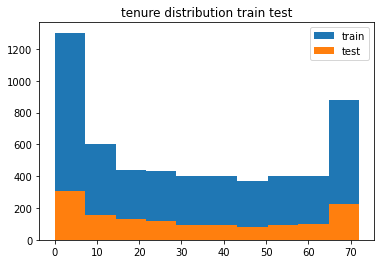

In [3]:
plt.figure()
plt.title(f"tenure distribution train test")
plt.hist(y_train)
plt.hist(y_test)
plt.legend(["train", "test"])
plt.show()

# Random model

In [7]:
rmin, rmax = y_train.min(), y_train.max()

# random uniform predictions
y_pred_random_train = np.random.randint(rmin, rmax, size=len(y_train))
y_pred_random_test = np.random.randint(rmin, rmax, size=len(y_test))

# metrics train
mse_random_train = mean_squared_error(y_train, y_pred_random_train)
rmse_random_train = mean_squared_error(y_train, y_pred_random_train, squared=False)

# metrics test
mse_random_test = mean_squared_error(y_test, y_pred_random_test)
rmse_random_test = mean_squared_error(y_test, y_pred_random_test, squared=False)

In [13]:
print(f"mse random train {mse_random_train}")
print(f"rmse random train {rmse_random_train}")
print()
print(f"mse random test {mse_random_test}")
print(f"rmse random test {rmse_random_test}")

mse random train 1040.1703940362088
rmse random train 32.25167273237481

mse random test 1025.5500354861604
rmse random test 32.024210146171605


# Time series split

In [15]:
x_train.columns

Index(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'Contract_1',
       'InternetService_1', 'InternetService_0'],
      dtype='object')

In [16]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

# Training Random Forest Model

## tuning num_estimators

In [17]:
num_estimators_list = [20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 400, 450, 500]

tscv_loss_dict = {}
for ix, ne in enumerate(num_estimators_list):
    print(f"num_estimators {ne}")

    tscv_loss_list = []

    for train_index, cv_index in tscv.split(x_train):

        # get data for cv ready
        x_train_req = x_train.iloc[train_index]
        x_cv_req = x_train.iloc[cv_index]

        y_train_req = y_train.iloc[train_index]
        y_cv_req = y_train.iloc[cv_index]

        # print(f"len_train {len(train_index)}, len_cv {len(cv_index)}")
        clf = RandomForestRegressor(n_estimators=ne,)
        clf.fit(x_train_req, y_train_req)

        # get log los train
        y_pred_train_mse = clf.predict(x_train_req)
        mse_train = mean_squared_error(y_train_req, y_pred_train_mse)
        rmse_train = mean_squared_error(y_train_req, y_pred_train_mse, squared=False)

        # get log los cv set
        y_pred_val_mse = clf.predict(x_cv_req)
        mse_cv = mean_squared_error(y_cv_req, y_pred_val_mse)
        rmse_cv = mean_squared_error(y_cv_req, y_pred_val_mse, squared=False)

        tscv_loss_list.append(
            {
                "mse_train": mse_train,
                "rmse_train": rmse_train,
                "mse_cv": mse_cv,
                "rmse_cv": rmse_cv,
            }
        )

    tscv_loss_dict[ix] = tscv_loss_list

num_estimators 20
num_estimators 30
num_estimators 40
num_estimators 50
num_estimators 60
num_estimators 70
num_estimators 100
num_estimators 150
num_estimators 200
num_estimators 250
num_estimators 300
num_estimators 400
num_estimators 450
num_estimators 500


In [24]:
df_tscv = pd.DataFrame(tscv_loss_dict.items()).rename(
    columns={0: "iteration", 1: "losses"}
)

df_tscv["mse_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["mse_train"] for i in x])
)
df_tscv["rmse_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["rmse_train"] for i in x])
)
df_tscv["mse_cv"] = df_tscv["losses"].apply(lambda x: np.mean([i["mse_cv"] for i in x]))
df_tscv["rmse_cv"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["rmse_cv"] for i in x])
)


df_tscv["num_estimators"] = num_estimators_list
df_tscv = df_tscv.drop(columns=["losses"])[
    ["iteration", "mse_train", "mse_cv", "rmse_train", "rmse_cv", "num_estimators"]
]
df_tscv

,iteration,mse_train,mse_cv,rmse_train,rmse_cv,num_estimators
0,0,0.940517,5.033036,0.954058,2.084008,20
1,1,0.923885,4.863732,0.947620,2.056762,30
2,2,0.851606,4.898051,0.912836,2.069567,40
3,3,0.841384,4.838754,0.904581,2.059965,50
4,4,0.768746,5.049761,0.868814,2.106409,60
5,5,0.833360,4.963808,0.902918,2.059240,70
6,6,0.811941,4.957029,0.891037,2.072705,100
7,7,0.791771,4.833586,0.879345,2.049654,150
8,8,0.787533,5.010157,0.877973,2.073141,200
9,9,0.788419,4.834286,0.877759,2.042037,250


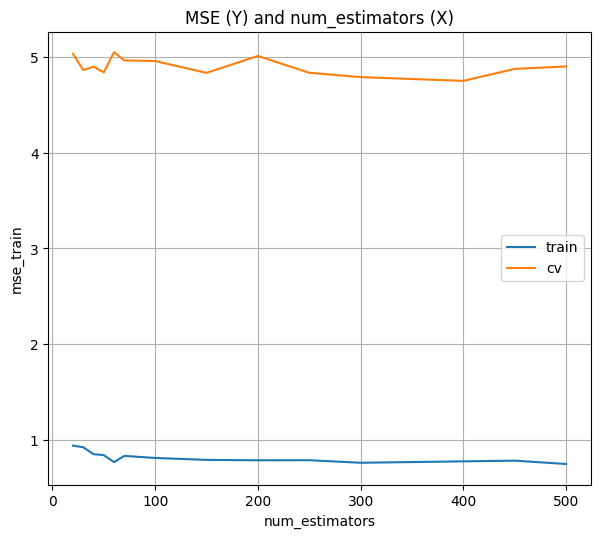

In [26]:
plt.figure(figsize=[7, 6], dpi=100)
plt.title(f"MSE (Y) and num_estimators (X)")
sns.lineplot(y="mse_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="mse_cv", x="num_estimators", data=df_tscv)

plt.legend(["train", "cv"])
plt.grid()

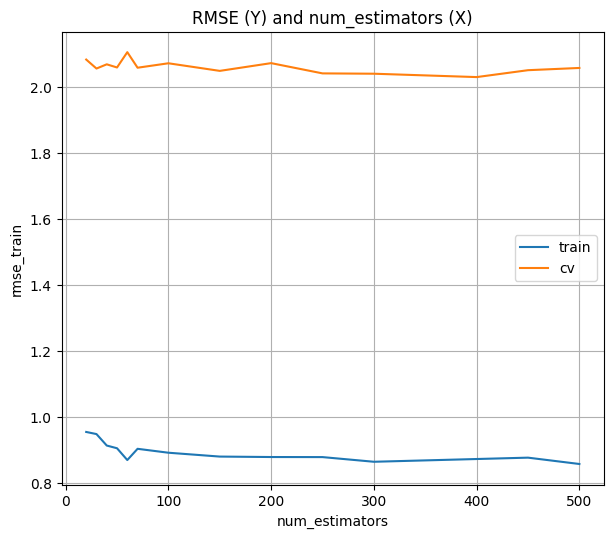

In [27]:
plt.figure(figsize=[7, 6], dpi=100)
plt.title(f"RMSE (Y) and num_estimators (X)")
sns.lineplot(y="rmse_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="rmse_cv", x="num_estimators", data=df_tscv)

plt.legend(["train", "cv"])
plt.grid()

Using `n_estimators = 150` as best param

## re-train with best num_estimators

In [29]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

In [30]:
clf = RandomForestRegressor(n_estimators=150)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

## Check mse

In [17]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 0.43859250976215824
mse test 5.557558339247693


In [32]:
root_mean_squared_error_train = mean_squared_error(y_train, y_pred_train, squared=False)
root_mean_squared_error_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"rmse train {root_mean_squared_error_train}")
print(f"rmse test {root_mean_squared_error_test}")

rmse train 0.6793420730317402
rmse test 2.359758127034597


1. rmse of random model was around -> 32
1. After training random forest we are getting rmse around -> 2
1. It is almost 16 times better than random model

# Fine tuning Random Forest Model

In [33]:
# using best n_estimators got from training

clf = RandomForestRegressor(n_estimators=150)


param_grid = {
    "max_depth": [100, 200, 300, None],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5],
}

grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=None,
    refit=True,
    scoring="neg_mean_squared_error",
)
grid_search_clf.fit(x_train, y_train)

%time

UsageError: Line magic function `%%time` not found.


In [34]:
grid_search_clf.best_params_

{'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [35]:
y_pred_train = grid_search_clf.predict(x_train)
y_pred_test = grid_search_clf.predict(x_test)

## Check mse

In [36]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 0.7325228079247196
mse test 5.534180644743874


In [38]:
root_mean_squared_error_train = mean_squared_error(y_train, y_pred_train, squared=False)
root_mean_squared_error_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"rmse train {root_mean_squared_error_train}")
print(f"rmse test {root_mean_squared_error_test}")

rmse train 0.8558754628593576
rmse test 2.3524839308152297


1. There is no much difference seen in rmse after fine tuning
1. rmse has reduced by as very small margin

# Save model

In [27]:
os.makedirs("../data/models/reg/random_forest/", exist_ok=True)

In [29]:
joblib.dump(
    grid_search_clf.best_estimator_, "../data/models/reg/random_forest/rf_model.pkl"
)

['../data/models/reg/random_forest/rf_model.pkl']